# Problem 1. Mushroom Weight and Height

In the class we build a naive bayes classifier which classify whether a mushroom is poisonous or edible. In the class, all the feature are of categorical type; it has a discrete number of outcome as opposed to real number.

In this problem we want to explore two ways to deal with real number features for Naive Bayes classifier.

## The Data
The data given to you is very similar to mushroom data. It has three features: cap-color(with the same dictionary we did in class), mushroom-weight(made up by me), mushroom-height(also made up by me).

The data is given in
`mushrooms_homework_test.csv`
and
`mushrooms_homework_train.csv`

## Task 1.1) Simplest way. Just bin it.

The simplest way for dealing with continuous value feature is to discretize it. The simplest way to discretize is just to bin it. For example if your data looks like

`data = (0.9, 1.1, 1.2, 2.1, 2.2, 4.2, 5.3, 5.1)`

We count bin it with bin edges of 

`bins = (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5)`

the bin number of a data point $x$ is the index $i$ where `bins[i-1] < x < bins[i]`. If $x$ is less than the minimum of bin edge then the bin number is 0. If $x$ is more than the maximum of bin edge then it's `len(bins)`.

Ex the data points above would be turned into
`binno = (0, 1, 1, 3, 3, 7, 8, 8)`

Once we discretize the value we can just use Bayes Classifier we did in class.

**Your task is to build a naive bayes classifier with binned height and binned weight. Pick appropriate bin edges somehow.
Then test your algorithm on the test data set. Report how many you got right and wrong in test data**


In [153]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import keyword
from IPython.display import set_matplotlib_formats
from pprint import pprint
import patternrekt as prekt
set_matplotlib_formats('retina')
plt.style.use('seaborn-notebook')

In [182]:
data = [0.9, 1.1, 1.2, 2.1, 2.2, 4.2, 5.3, 5.1]
bins = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
def discretize_data(data, bins):
    binno = []
    for x in data:
        if x <= min(bins):
            binno.append(0)
        elif x >= max(bins):
            binno.append(len(bins))
        else:
            for i in range(len(bins)):
                if bins[i-1] < x and x < bins[i]:
                    binno.append(i)
    return binno 
print(discretize_data(data, bins))

[0, 1, 1, 3, 3, 7, 9, 9]


In [183]:
#Read data from mushrooms_homework_train.csv
df = pd.read_csv('data/mushrooms_homework_train.csv')
# df.columns

In [184]:
df.describe()

,weight,height
count,6507.000000,6507.000000
mean,3.774465,5.510702
std,1.280863,1.756133
min,1.000885,2.001143
25%,2.869634,4.235949
50%,3.691409,5.400473
75%,4.599898,6.646482
max,8.427455,14.727778


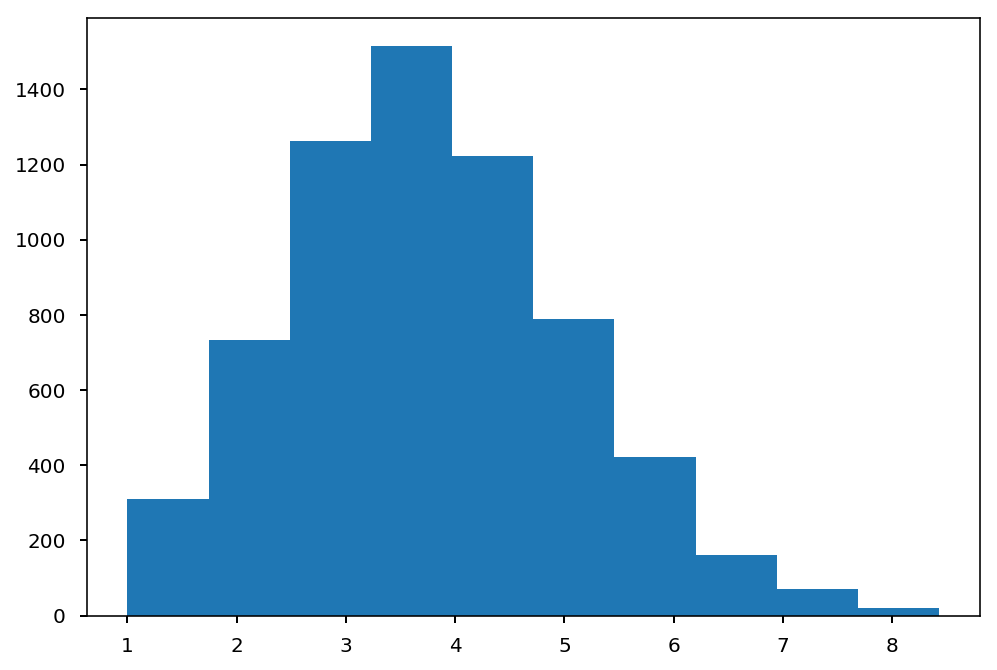

In [185]:
plt.hist(df.weight)
plt.show()

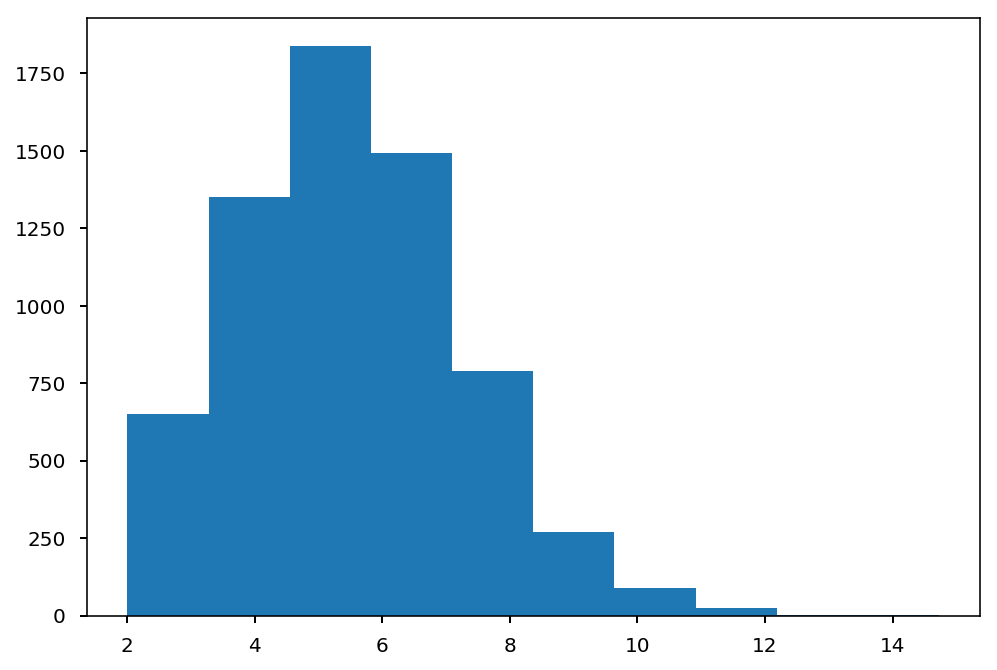

In [186]:
plt.hist(df.height, bins=10)
plt.show()

In [187]:
h_bins = np.linspace(1,12,20)
discretized_weight = discretize_data(df.weight, h_bins)
discretized_height = discretize_data(df.height, h_bins)

[(8, {'total': 855, 'p': 503, 'e': 352}),
 (7, {'total': 815, 'p': 503, 'e': 312}),
 (9, {'total': 795, 'p': 388, 'e': 407}),
 (6, {'total': 685, 'p': 433, 'e': 252}),
 (10, {'total': 670, 'p': 267, 'e': 403}),
 (5, {'total': 541, 'p': 329, 'e': 212}),
 (11, {'total': 524, 'p': 194, 'e': 330}),
 (12, {'total': 387, 'p': 110, 'e': 277}),
 (4, {'total': 353, 'p': 202, 'e': 151}),
 (3, {'total': 266, 'p': 156, 'e': 110}),
 (13, {'total': 222, 'p': 31, 'e': 191}),
 (14, {'total': 127, 'p': 19, 'e': 108}),
 (15, {'total': 101, 'p': 6, 'e': 95}),
 (16, {'total': 61, 'p': 4, 'e': 57}),
 (2, {'total': 57, 'p': 34, 'e': 23}),
 (17, {'total': 21, 'p': 1, 'e': 20}),
 (18, {'total': 18, 'p': 0, 'e': 18}),
 (19, {'total': 7, 'p': 0, 'e': 7}),
 (20, {'total': 2, 'p': 0, 'e': 2})]

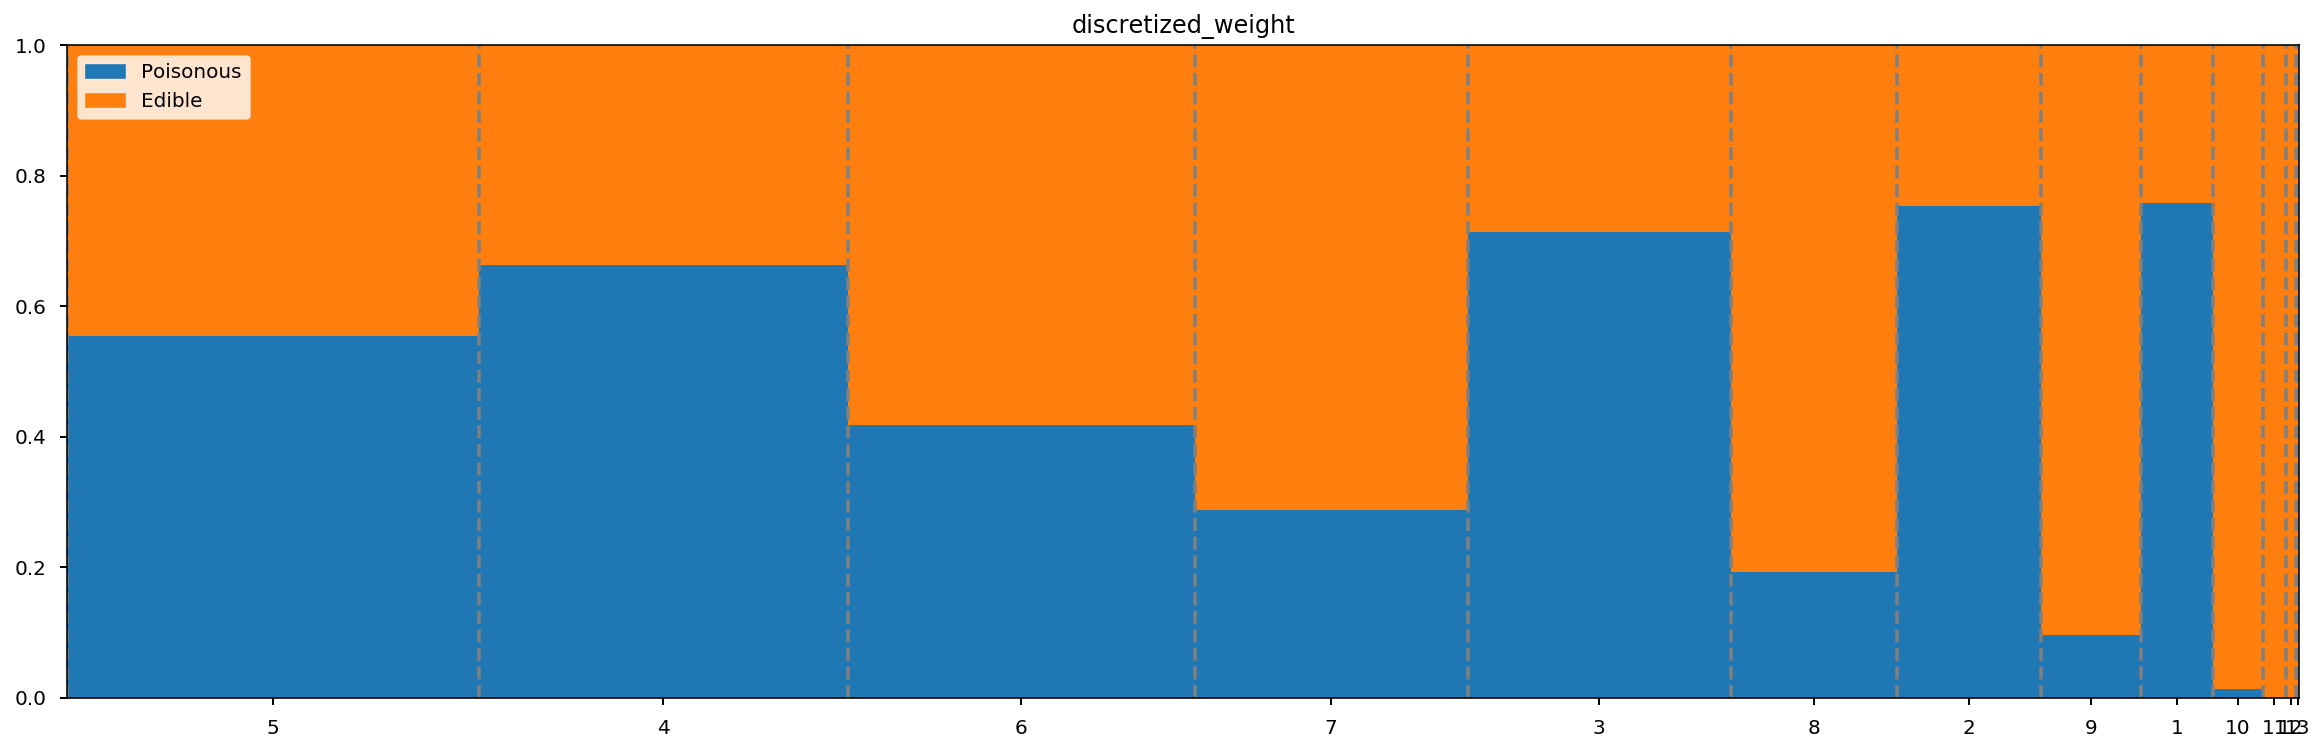

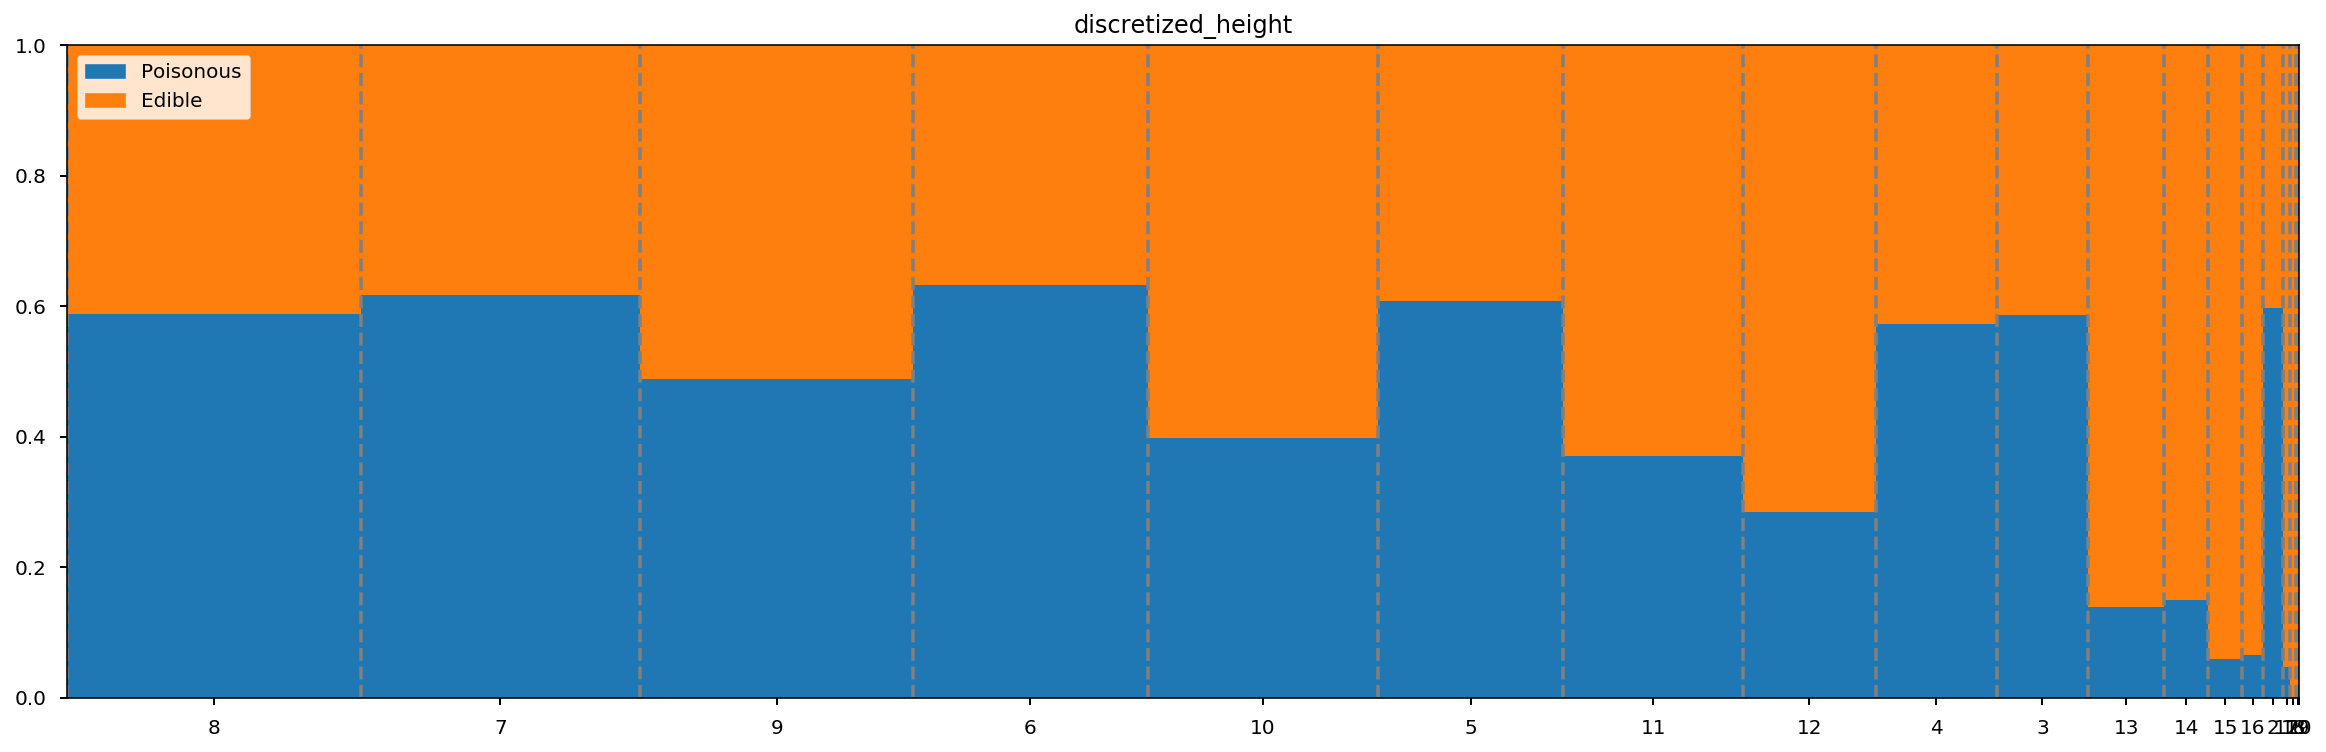

In [188]:
d = {'xclass': df.xclass,'cap_color': df.cap_color, 'discretized_weight': discretized_weight, 'discretized_height': discretized_height}
pf = pd.DataFrame(data=d)
# for col in pf.columns:
#        prekt.mushroom_plot( pf[col], df.xclass, legend_map={'p': 'Poisonous', 'e': 'Edible'})
prekt.mushroom_plot( pf.discretized_weight, df.xclass, legend_map={'p': 'Poisonous', 'e': 'Edible'})
prekt.mushroom_plot( pf.discretized_height, df.xclass, legend_map={'p': 'Poisonous', 'e': 'Edible'})

In [189]:
class NaiveBayes:
    def __init__(self, df, class_col):
        self.df = df
        self.class_col = class_col
        self.cache= {}
        for clazz in df[class_col].unique():
            for feature in df.columns:
                for val in df[feature].unique():
                    key = (feature, val, clazz)
                    val = len(df[(df[feature]== val) & (df[class_col]==clazz)])/len(df[(df[class_col]==clazz)])
                    self.cache[key]=val
        
        self.prior = {}
        for clazz in df[class_col].unique(): #xclass
            self.prior[clazz] = len(df[(df[class_col]==clazz)])/len(df)
        
    # ex: cond_prof('cap_color','r','e') => P(cap_color==red|edible)
    def cond_prob(self, feature_col, feature_value, class_value):
#          return P(feature_col==feature_value | class_col==class_value)
        return self.cache[( feature_col, feature_value, class_value)]

    def top_part(self, mushroom, clazz):
        p = self.prior[clazz]
        mdict = mushroom._asdict()
        for (k,v) in mdict.items():
            if k not in set(['Index', self.class_col]):
                p*= self.cond_prob(k,v,clazz)
        return p 
    
    def evidence(self, mushroom):
        return self.top_part(mushroom, 'e') + self.top_part(mushroom,'p')
              
    #mushroom is stuff you got from itertuple
    def prob_edible(self, mushroom):
#         return P(edible | all mushroom features)
        return self.top_part(mushroom,'e')/ self.evidence(mushroom)

4764 1743
73.21346242508068


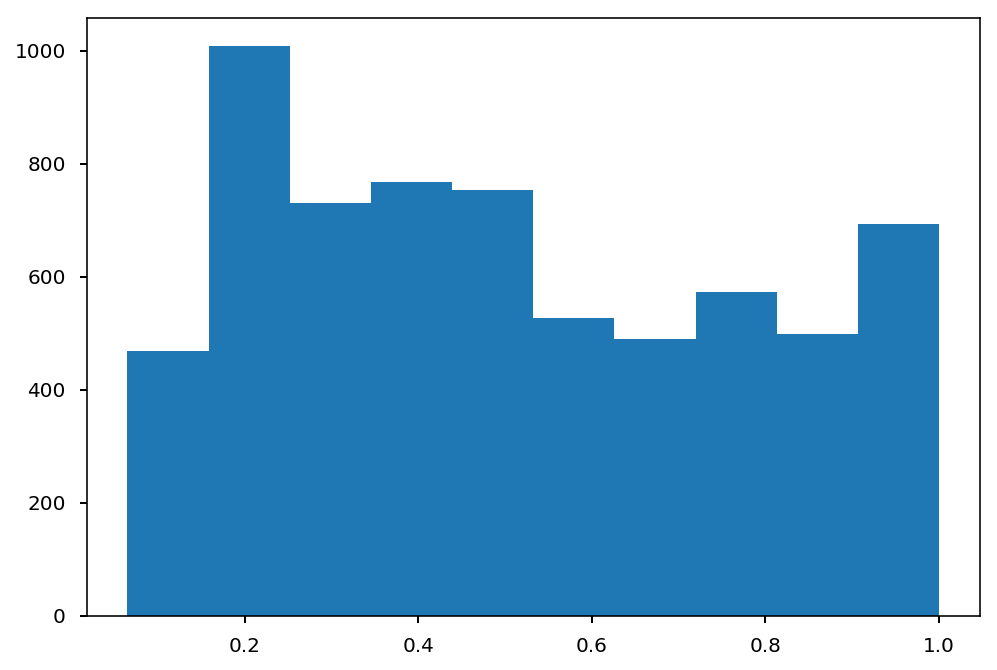

In [190]:
#train
good = 0
bad = 0
nb = NaiveBayes(pf, 'xclass')
tmp = []
for mushroom in pf.itertuples():
    p = nb.prob_edible(mushroom)
    tmp.append(p)
    if (p > 0.5 and mushroom.xclass=='e') or (p <= 0.5 and mushroom.xclass=='p'):  #edible
        good+=1 
    else:
        bad+=1
print(good, bad)
print(good/len(df)*100)
plt.hist(tmp)
plt.show()

1211 406
74.89177489177489


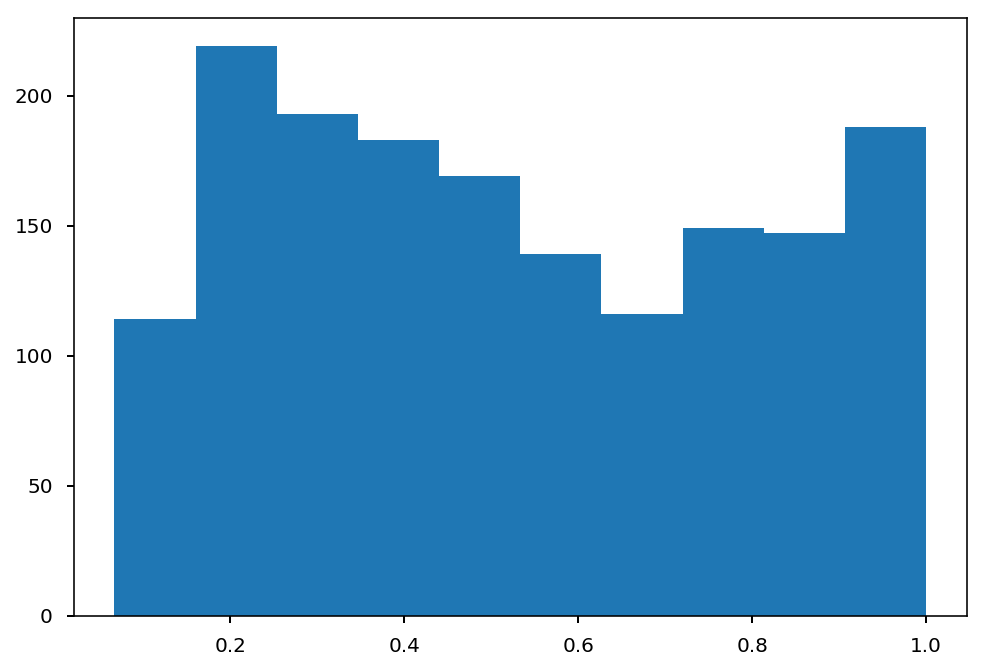

In [191]:
#test
test = pd.read_csv('data/mushrooms_homework_test.csv')
h_bins = np.linspace(1,12,20)
new_weight = discretize_data(test.weight, h_bins)
new_height = discretize_data(test.height, h_bins)

d = {'xclass': test.xclass, 'cap_color': test.cap_color , 'discretized_weight': new_weight, 'discretized_height': new_height}
new_data = pd.DataFrame(data=d)

good = 0
bad = 0
nb = NaiveBayes(pf, 'xclass')
ntmp = []
for mushroom in new_data.itertuples():
    p = nb.prob_edible(mushroom)
    ntmp.append(p)
    if (p > 0.5 and mushroom.xclass=='e') or (p <= 0.5 and mushroom.xclass=='p'):  #edible
        good+=1 
    else:
        bad+=1
print(good, bad)
print(good/len(new_data)*100)
plt.hist(ntmp)
plt.show()

## Task 1.2) Gaussian Naive Bayes.

We could assume a certain probability distribution function(pdf) for the conditional probability. One popular choice is normal distrubution/gaussian distribution.

Let us understand this assumption intuitively. The idea is that the *weight* of *poisonous* mushroom is normally distributed around some mean with some width while the *weight* for edible mushroom is hopefully normally distributed around some other mean.

Let us say that the weight of poisonous mushroom is normally distributed around $2\pm1$ gram(I made up this number)  while the edible mushroom is normally distributed at $5\pm 1$ gram. If we found a mushroom of 2.5 gram. It's probably the poisonous one since edible one should weight around 5 gram.

<img src="gaussian.png" width="400"/>

Concretely, we assume that the probability distribution of feature $X$ given that it is of class $y$ to be

$$
\displaystyle
pdf(X=x|y) = \frac{1}{\sqrt{2\pi}} \exp\left[\frac{-(x-\mu_y)^2}{2\sigma_y^2}\right]
$$

 - $\mu_y$ is the mean of feature $X$ given that it is of class $y$. Ex: mean weight($X$) of poisonous mushroom (eg: 2 gram).

 - $\sigma_y$ is the standard deviation of feature $X$ given that it is of class $y$. Ex std. dev. of weight of poisonous mushroom(eg: \pm 1 gram)
 
Recall the relatio between pdf and probability.
$$
    P(X \in (x, x+\delta x)|y) = \int^{x+\delta x}_x pdf(X=x) \;\text{d}x
$$

for small enough $\delta x$ it becomes
$$
    P(X \in (x, x+\delta x)|y) = pdf(X=x) \delta x
$$

Now here is the important part. From the above $P(X=x|y)$ and $P(X=x|\sim y)$ has a factor of $\delta x$(I drop of the range for brevity). This means that the factor of $\delta x$ appear in both the numerator and denominator of the formula we use for calculating probability. Thus the $\delta x$ cancels out nicely. This means that **we can just use pdf(X=x|y) as P(X=x|y)** in naive bayes formula we got and every thing will just work out. We don't have to worry about the $\delta x$ part

**Your task: build a classifier similar to what you did in 1.1. Except now you use gaussian distribution assumption for the continous features. Measure your performance against the test data**

In [167]:
class GaussianNaiveBayes:
    def __init__(self, df, class_col):
        self.df = df
        self.class_col = class_col
        self.cache= {}
        for clazz in df[class_col].unique():
            col = df[(df[class_col]== clazz)]   
            mu = np.mean(col)      #mean of class y ('p'/'e')
            std = np.std(col)      #std of class y ('p'/'e')
            for feature in df.columns:
                for val in df[feature].unique():
                    key = (feature, val, clazz)
                    if feature not in set(['cap_color','xclass']):   #for continuous features 
                        muy = mu[feature]
                        stdy = std[feature]
                        val = 1/np.sqrt(2*np.pi)*np.exp(-(val-muy)**2/(2*stdy**2))
                    else: 
                        val = len(df[(df[feature]== val) & (df[class_col]==clazz)])/len(df[(df[class_col]==clazz)])
                    self.cache[key]=val    
        self.prior = {}
        for clazz in df[class_col].unique(): #xclass
            self.prior[clazz] = len(df[(df[class_col]==clazz)])/len(df)
        
    # ex: cond_prof('cap_color','r','e') => P(cap_color==red|edible)
    def cond_prob(self, feature_col, feature_value, class_value):
#          return P(feature_col==feature_value | class_col==class_value)
        return self.cache[( feature_col, feature_value, class_value)]

    def top_part(self, mushroom, clazz):
        p = self.prior[clazz]
        mdict = mushroom._asdict()
        for (k,v) in mdict.items():
            if k not in set(['Index', self.class_col]):
                p*= self.cond_prob(k,v,clazz)
        return p 
    
    def evidence(self, mushroom):
        return self.top_part(mushroom, 'e') + self.top_part(mushroom,'p')
              
    #mushroom is stuff you got from itertuple
    def prob_edible(self, mushroom):
#         return P(edible | all mushroom features)
        return self.top_part(mushroom,'e')/ self.evidence(mushroom)

In [168]:
#train
df = pd.read_csv('data/mushrooms_homework_train.csv')
good = 0
bad = 0
nb = GaussianNaiveBayes(df, 'xclass')
tmp = []
for mushroom in df.itertuples():
    p = nb.prob_edible(mushroom)
    tmp.append(p)
    if (p > 0.5 and mushroom.xclass=='e') or (p <= 0.5 and mushroom.xclass=='p'):  #edible
        good+=1 
    else:
        bad+=1
print(good, bad)
print(good/len(df)*100)

4691 1816
72.09159366835716


In [169]:
#test
test = pd.read_csv('data/mushrooms_homework_test.csv')
good = 0
bad = 0
nb = GaussianNaiveBayes(test, 'xclass')
ntmp = []
for mushroom in test.itertuples():
    p = nb.prob_edible(mushroom)
    ntmp.append(p)
    if (p > 0.5 and mushroom.xclass=='e') or (p <= 0.5 and mushroom.xclass=='p'):  #edible
        good+=1 
    else:
        bad+=1
print("good:",good, "bad:", bad)
print(good/len(test)*100)

good: 1187 bad: 430
73.40754483611627


# Problem 2. Product Reviews

Naive Bayes is quite powerful given its simplicity. Typically the usefulness of a Machine learning Algorithm is limited only by your imgination on what to ask. If you ask an interesting question, you got a useful system. If you ask a dump question, you got a useless system.

In this problem we will explore a text mining application using Naive Bayes.

The goal of this problem is to make a system that can read customer review and tells whether the customer recommend the product to others or not.

The data is stolen from https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews
I splitted it into train(`clothing_reviews_train.csv`) and test(`clothing_reviews_test.csv`) for you.

The two columns that is relavant to this problem are.
- Recommended IND
- Title
- Review Text

**Do not use any other column**

You could do challenging version (No extra point except for bragging rights)
Use the data from http://jmcauley.ucsd.edu/data/amazon/ and do similar thing --> the book review is hugeeeeee


## Your task
Build a classifier which you can give it a reviewtext and review title and it can split out whether the reviewer recommend the product or not. Measure the performance on test data `clothing_reviews_test.csv`.

## Some Guide for you.

- Be sure to normalize your text. Example [here](https://machinelearningmastery.com/clean-text-machine-learning-python/). This includes
    - lowercase everything
    - clean out stop words
    - get rid of punctuations
    - stem the word
    - Yes you may use nltk only for cleaning up part.
- Be careful as you are multiplying a whole bunch of small numbers together. You are better off adding the log and exponentiate it back.
- Read up lecture notes on spam filtering. Especially on how to deal with missing words. You can read up [old version of excercise 1 from sam](https://github.com/KongsakTi/PatternReg/tree/master/Exercise%201)
- **Do not** get stuck on this alone. Find help/Consult your friends if you are stuck. Collaboration is allowed but you must understand what you send in.

In [119]:
#read data 
rd = pd.read_csv('data/clothing_reviews_train.csv', usecols=['Title','Review Text','Recommended IND'])[['Title','Review Text','Recommended IND']]
rd.columns = rd.columns \
    .str.strip() \
    .str.lower() \
    .str.replace(' ', '_') \
    .str.replace('(', '') \
    .str.replace(')', '') \
    .str.replace('-','_') \
    .map(lambda x: 'x'+x if x in keyword.kwlist else x )
    
rd.review_text = rd.title + " " + rd.review_text
d = {'review_text': rd.review_text, 'recommended_ind': rd.recommended_ind}
rv = pd.DataFrame(data=d)
rv.review_text = rd.review_text.fillna('')
# rv.head()

In [120]:
#Normalizing case
rv.review_text = rv['review_text'].str.lower()

In [121]:
import string as string
#get rid of punctuations
table = str.maketrans('', '', string.punctuation)
rv.review_text = rv.review_text.apply(lambda x: x.translate(table))

In [122]:
#clean out stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

def filter_stop_word(words):
    word = []
    tokens = word_tokenize(words)
    for w in tokens:
        if w not in stop_words:
            word.append(w)
    return word

rv.review_text = rv.review_text.apply(lambda words: filter_stop_word(words))

In [123]:
#clean up stem the word
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def stem_word(words):
    stemmed = [porter.stem(word) for word in words]
    return stemmed

rv.review_text = rv.review_text.apply(lambda words: stem_word(words))

In [124]:
#separate yes, no reviews 
yes=[]
no=[]
for rev in rv.itertuples():
    if rev.recommended_ind == 1: #yes 
        yes += rev.review_text
    else:
        no += rev.review_text

In [125]:
def find_prob(reviews):         # probs of word in each reviews 
    total_words = len(reviews)
    unique_words, counts_words = np.unique(reviews, return_counts=True)    #count the number of each word from all reviews
    prob = { k: v/total_words for k,v in zip(unique_words, counts_words)}  #divide by the total number of words that appear in all reviews
    return prob
probs_yes = find_prob(yes)
probs_no = find_prob(no)

In [126]:
#prior 
yes_prior = len(rv[rv.recommended_ind==1])/len(rv)
no_prior = len(rv[rv.recommended_ind==0])/len(rv)
print(yes_prior, no_prior)

0.8220217564340674 0.17797824356593261


In [150]:
def naiveBayes(review, probs, prior):
    p = np.log(prior)
    for word in review:
        if word in probs:           
            p_word = probs[word]    # probs of that word
            p+= np.log(p_word)
    return np.exp(p)

def find_good_review(rev):
    pYes = naiveBayes(rev.review_text, probs_yes, yes_prior)
    pNo = naiveBayes(rev.review_text, probs_no, no_prior)
    good_review = pYes/(pYes+pNo)
    return good_review, 1-good_review


In [151]:
p_yes = []
p_no = []
good_yes=0
good_no=0
for rev in rv.itertuples():
    if rev.recommended_ind == 1: #yes 
        p = find_good_review(rev)[0]
        p_yes.append(p)
        if (p > 0.5):
            good_yes+=1
    else:
        p = find_good_review(rev)[1]
        p_no.append(p)
        if (p > 0.5):
            good_no+=1
print((good_yes+good_no)/len(rv)*100)

56.094454762536486


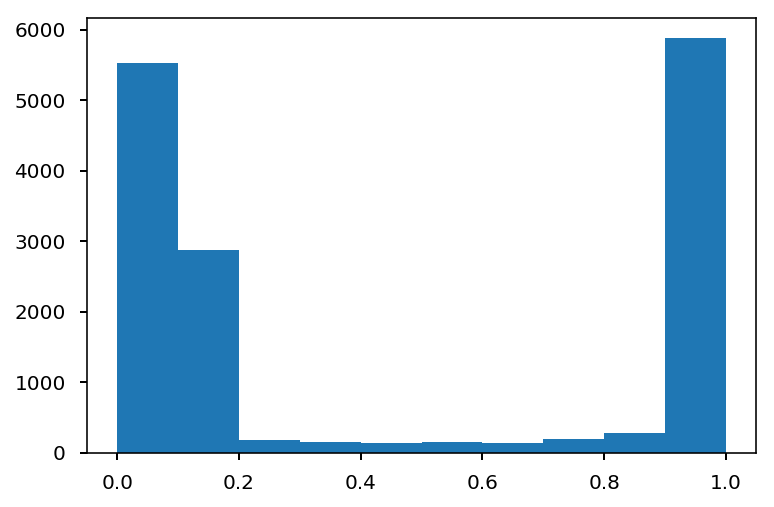

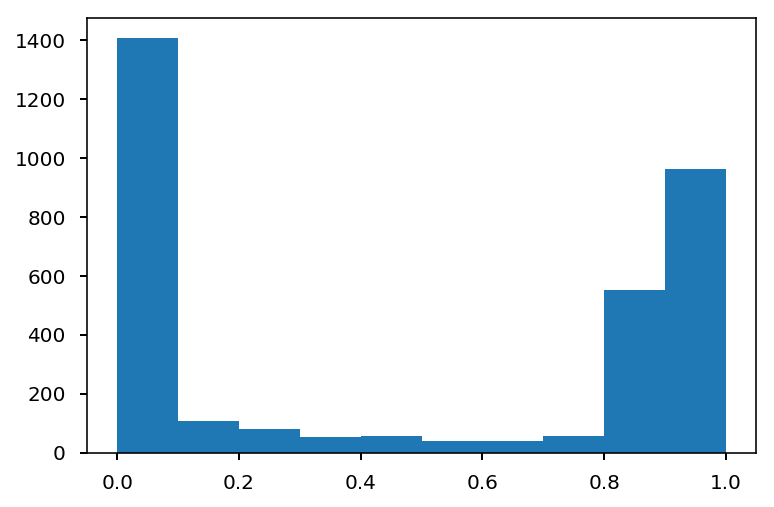

In [147]:
plt.hist(p_yes)
plt.figure()
plt.hist(p_no)
plt.show()